# Single Peak Extraction

In this notebook, we first find valid subjects for extracting a single peak.
These are subjects where the number of peaks across channels is consistent,
the interbeat standard deviation is pretty low, and the heart rate is reasonable.

In [1]:
import sys
sys.path.append('../')

from resnet import ResNet1d
import h5py
from itertools import product
import torch
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.stats import skew

In [2]:
peak_prominence_for_detection = 0.75  # Minimum prominence required to retain a peak
inter_beat_sd_percentile = 0.90  # Percentile of standard deviations of inter beat SDs to set a cutoff for retention
mode_cutoff = 9  # Minimum number of channels with the same number of peaks required for retention
hr_low = 50  # Lowest HR for retention
hr_high = 120  # Highest HR for retention

In [3]:
from constants import (
    DATA_DIR,
    N_LEADS,
)
config = '../model/config.json'

# Instantiate the model using the config.json information.
with open(config, 'r') as f:
    config_dict = json.load(f)
model = ResNet1d(
    input_dim=(N_LEADS, config_dict['seq_length']),
    blocks_dim=list(zip(config_dict['net_filter_size'], config_dict['net_seq_lengh'])),
    n_classes=1,
    kernel_size=config_dict['kernel_size'],
    dropout_rate=config_dict['dropout_rate']
)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Retrieve the state dict, which has all the coefficients
state_dict = (torch.load('../model/model.pth',
              weights_only=False,
              map_location=device))

# Load the state dict and set the model to eval mode.
model.load_state_dict(state_dict['model'])
model.eval()

# Read in exam metadata and limit to file 16.
df = pd.read_csv(f'{DATA_DIR}/exams.csv')
df = df[df['trace_file'] == 'exams_part16.hdf5']

# Read in raw ECG data for file 16.
filename = "../data/exams_part16.hdf5"

with h5py.File(filename, "r") as f:
    print("Keys in the HDF5 file:", list(f.keys()))
    dataset = f['tracings']
    print("Dataset shape:", dataset.shape)
    print("Dataset dtype:", dataset.dtype)
    data_array = f['tracings'][()]
    exam_ids = f['exam_id'][()]


Keys in the HDF5 file: ['exam_id', 'tracings']
Dataset shape: (20001, 4096, 12)
Dataset dtype: float32


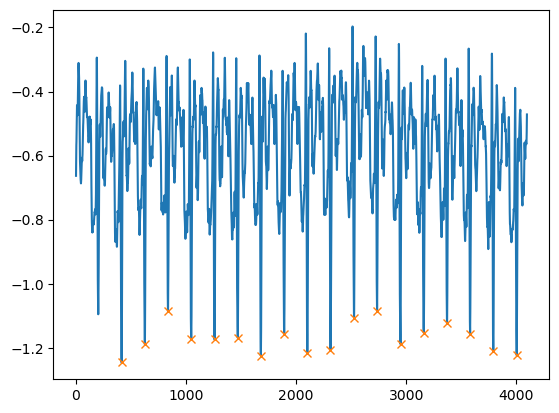

In [4]:
# Play around with different subjects and channels to see what peaks are detected.
subject = 4
channel = 0
series = data_array[subject, :, channel]
if skew(series) < 0:
    series = -series
peaks, _ = find_peaks(series, prominence=(peak_prominence_for_detection, None))
plt.plot(data_array[subject, :, channel])
plt.plot(peaks, data_array[subject, :, channel][peaks], "x")
plt.show()

In [5]:
# For each subject and channel, calculate the number of peaks,
# the location of peaks,
# and the standard deviation of the interbeat intervals.
# This takes about 3 minutes.
summary_frame = pd.DataFrame(product(range(data_array.shape[0]), range(data_array.shape[2])),
                             columns=['subject', 'channel'])
summary_frame['n_peaks'] = np.nan
peak_list = []
summary_frame['inter_beat_sd'] = np.nan
for subject in range(data_array.shape[0]):
    if (subject + 1) % 1000 == 0:
        print('Subject ', subject + 1, ' of ', data_array.shape[0] + 1)
    for channel in range(12):
        series = data_array[subject, :, channel]
        if skew(series) < 0:
            series = -series
        peaks, _ = find_peaks(series, prominence=(peak_prominence_for_detection, None))
        n_peaks = len(peaks)
        inter_beat_sd = np.nan
        if n_peaks > 2:
            inter_beat_sd = np.std(np.diff(peaks))
        mask = (summary_frame['subject'] == subject) & (summary_frame['channel'] == channel)
        summary_frame.loc[mask, 'n_peaks'] = n_peaks
        summary_frame.loc[mask, 'inter_beat_sd'] = inter_beat_sd
        peak_list.append(peaks)
summary_frame['peaks'] = peak_list


Subject  1000  of  20002
Subject  2000  of  20002
Subject  3000  of  20002
Subject  4000  of  20002
Subject  5000  of  20002
Subject  6000  of  20002
Subject  7000  of  20002
Subject  8000  of  20002
Subject  9000  of  20002
Subject  10000  of  20002
Subject  11000  of  20002
Subject  12000  of  20002
Subject  13000  of  20002
Subject  14000  of  20002
Subject  15000  of  20002
Subject  16000  of  20002
Subject  17000  of  20002
Subject  18000  of  20002
Subject  19000  of  20002
Subject  20000  of  20002


In [6]:
summary_frame.head()

,subject,channel,n_peaks,inter_beat_sd,peaks
0,0,0,9.0,9.096703,"[211, 670, 1118, 1560, 2002, 2443, 2885, 3314,..."
1,0,1,9.0,9.137833,"[212, 671, 1119, 1561, 2004, 2444, 2886, 3316,..."
2,0,2,3.0,656.500000,"[1123, 1565, 3320]"
3,0,3,9.0,9.124144,"[211, 670, 1118, 1560, 2003, 2444, 2885, 3315,..."
4,0,4,9.0,9.096703,"[210, 669, 1117, 1559, 2001, 2443, 2884, 3313,..."


In [7]:
# For each subject, calculate the size of the mode of the number of peaks
modes = summary_frame.groupby('subject')['n_peaks'].value_counts().reset_index()
modes = modes.groupby('subject').first().reset_index()

# Find out what the most common mode is
modes['count'].value_counts()
# Having 4, 5, 6, 7, 8, 9, 10 channels with the same number of peaks is about
# equally common.

count
6     2592
7     2576
8     2511
5     2448
9     2390
10    2095
4     1956
3     1297
11    1239
12     539
2      354
1        4
Name: count, dtype: int64

In [8]:
modes.rename(columns={'n_peaks': 'mode_n_peaks',
                      'count': 'mode_count'}, inplace=True)
summary_frame = summary_frame.merge(modes[['subject', 'mode_n_peaks', 'mode_count']], how='inner', on='subject')
summary_frame.head()

,subject,channel,n_peaks,inter_beat_sd,peaks,mode_n_peaks,mode_count
0,0,0,9.0,9.096703,"[211, 670, 1118, 1560, 2002, 2443, 2885, 3314,...",9.0,10
1,0,1,9.0,9.137833,"[212, 671, 1119, 1561, 2004, 2444, 2886, 3316,...",9.0,10
2,0,2,3.0,656.500000,"[1123, 1565, 3320]",9.0,10
3,0,3,9.0,9.124144,"[211, 670, 1118, 1560, 2003, 2444, 2885, 3315,...",9.0,10
4,0,4,9.0,9.096703,"[210, 669, 1117, 1559, 2001, 2443, 2884, 3313,...",9.0,10


In [9]:
# Add the heart rate from the most common peak count
temp = summary_frame[summary_frame['n_peaks'] == summary_frame['mode_n_peaks']].copy()
temp['hr'] = temp['n_peaks'] * 60 / 10
temp = temp.groupby('subject')['hr'].first().reset_index()
summary_frame = summary_frame.merge(temp, on='subject', how='left')

In [10]:
# Find the inter_beat_sd_percentile^th percentile of the inter_beat_sd
inter_beat_sd_cutoff = np.nanquantile(summary_frame['inter_beat_sd'], inter_beat_sd_percentile)

# For each subject, get the average inter beat sd using only the channels
# where the number of peaks is the mode number of peaks.
avg_inter_beat_sd = (
    summary_frame
    .loc[summary_frame['n_peaks'] == summary_frame['mode_n_peaks']]
    .groupby('subject')
    ['inter_beat_sd']
    .mean()
    .reset_index()
)
avg_inter_beat_sd.rename(columns={'inter_beat_sd': 'avg_inter_beat_sd'}, inplace=True)
summary_frame = summary_frame.merge(avg_inter_beat_sd, on='subject', how='left')

In [11]:
# Flag subjects to retain if they have at least 9 channels with the same
# number of beats, an average inter_beat_sd on those channels less than the cutoff, 
# and a heart rate between 50 and 120
summary_frame['retain_subject'] = (
    (summary_frame['mode_count'] >= mode_cutoff)
    & (summary_frame['avg_inter_beat_sd'] < inter_beat_sd_cutoff)
    & ((summary_frame['hr'] >= hr_low) & (summary_frame['hr'] <= hr_high))
)


In [12]:
summary_frame.head()

,subject,channel,n_peaks,inter_beat_sd,peaks,mode_n_peaks,mode_count,hr,avg_inter_beat_sd,retain_subject
0,0,0,9.0,9.096703,"[211, 670, 1118, 1560, 2002, 2443, 2885, 3314,...",9.0,10,54.0,9.104809,True
1,0,1,9.0,9.137833,"[212, 671, 1119, 1561, 2004, 2444, 2886, 3316,...",9.0,10,54.0,9.104809,True
2,0,2,3.0,656.500000,"[1123, 1565, 3320]",9.0,10,54.0,9.104809,True
3,0,3,9.0,9.124144,"[211, 670, 1118, 1560, 2003, 2444, 2885, 3315,...",9.0,10,54.0,9.104809,True
4,0,4,9.0,9.096703,"[210, 669, 1117, 1559, 2001, 2443, 2884, 3313,...",9.0,10,54.0,9.104809,True


In [13]:
# The number of subjects retained is the number of retain flags
# divided by the number of channels. This should be an integer or
# something has gone wrong.
np.sum(summary_frame['retain_subject']) / 12

np.float64(4362.0)